## Problem Statement

Max is a fashion brand within Landmark Group and has launched 4 new stores in the year 2018. The objective is to determine whether an existing customer of Max UAE will shop in each of the new stores.
31 stores are already running and we have historical data for these stores. 

## Data Details

### We have three datasets.

- **Customer_Demographics**: Customer demographics details for 100k customers.
- **Customer_Transaction**: Customer-Store-Week level transaction details for the last two years.
- **Store_Master**: Store attribute details.

Details can be found here -
__[LMG Hackathon](https://www.hackerearth.com/challenge/hiring/LMG-analytics-data-science-hiring-challenge/machine-learning/max-customer-classification-to-shop-in-a-new-store/)__

There are 2 ways to solve this problem. 
- Machine Learning way
- Use distance between each store and then formulate hypothesis based on that.

## 1. ML Way

Below code is to hide cell

In [18]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

**Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
sns.set()

### Importing all the 3 datasets

In [4]:
%%time
tran_data = pd.read_excel("Customer_Transaction.xlsx")
store_data = pd.read_excel("Store_Master.xlsx")
demo_data = pd.read_excel("Customer_Demographics.xlsx")

Wall time: 1min 56s


In [5]:
print('Transaction Data : ',tran_data.shape)
print('Store Data : ',store_data.shape)
print('Demographics Data : ',demo_data.shape)

Transaction Data :  (544649, 15)
Store Data :  (35, 15)
Demographics Data :  (100000, 16)


In [6]:
tran_data.head()

,Territory,Business,Year,Week,Store_Code,City_Name,Store_Type,Transaction_Type,Return_Reason,Customer_ID,Invoices,Item_Count,Revenue,Discount,Units_Sold
0,United Arab Emirates,Max,2010,0,60065,Dubai,Stand alone,Return,Size Problem,1800000058056860,1,3,-169.0,0.0,-3
1,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000020917140,1,1,0.0,0.0,0
2,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000021265010,1,1,0.0,0.0,0
3,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000025693950,1,4,0.0,0.0,0
4,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000044104620,1,1,0.0,0.0,0


In [7]:
store_data.head()

,Territory,Business,Region,Region_Code,Store_Code,Store_Name,Mall_Name,Store_Format,Sales_Per_Day,Store_Launch_Date,Train_Test_Store,Geo_Field,Store_Size_Sq_Ft,Customer_Count,Total_Revenue
0,United Arab Emirates,Max,MX - Abu Dhabi,602,60077,Max Zayed City Mall,City Mall - Abu Dhabi-Uae,NaN,544.074849,2011-11-02,Train,"25.618167, 53.441646",4852.220341,22237.0,1.131676e+07
1,United Arab Emirates,Max,MX - Sharjah,606,60073,Max Safeer Mall,Safeer Mall Sharjah-Uae,NaN,1251.656549,2009-08-21,Train,"25.309997, 55.378550",13789.949661,88372.0,2.603446e+07
2,United Arab Emirates,Max,MX - Dubai,601,60065,Max Gardens,Ibn Battuta Mall-Uae,NaN,3319.885702,2005-04-15,Train,"25.044684, 55.120275",15609.687991,188836.0,6.905362e+07
3,United Arab Emirates,Max,MX - Dubai,601,60219,MX -Dubai Festival City,Dubai Festival City-Uae,Stand Alone Stores,1211.477261,2014-06-12,Train,"25.218486, 55.359313",6845.497058,96733.0,2.519873e+07
4,United Arab Emirates,Max,MX - Ras Al Khaimah,605,60071,Max Rak,STANDALONE,NaN,2221.872874,2006-03-20,Train,NaN,12385.047461,70456.0,4.621496e+07


In [8]:
demo_data.head()

,Customer_ID,Territory,Nationality,Income_Range,Job_Type,Marital_Status,Gender,State,Language,Loyalty_Status,Birth_date,Age,Points,First_txn_dt,Last_accr_txn_dt,Last_rdm_txn_dt
0,1800000006365760,United Arab Emirates,INDIA,Below 5000,Services,Married,M,Abu Dhabi,English,Gold,01JUN1959:00:00:00,59.0,814.0,02NOV2010:00:00:00,27SEP2018:21:45:25,11MAR2018:19:11:57
1,1800000006365820,United Arab Emirates,UNITED ARAB EMIRATES,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,NaN,212.0,06DEC2010:00:00:00,16AUG2016:21:08:28,16MAR2015:13:39:12
2,1800000006366060,United Arab Emirates,SRI LANKA,Below 5000,Services,Married,M,Abu Dhabi,English,Silver,07JUN1959:00:00:00,59.0,186.0,17FEB2011:00:00:00,31AUG2018:20:52:18,30JAN2017:19:19:19
3,1800000006366230,United Arab Emirates,JORDAN,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,21JAN1962:00:00:00,57.0,126.0,30OCT2010:00:00:00,30JUL2018:20:30:05,20JUN2017:17:57:27
4,1800000006366570,United Arab Emirates,OCCUPIED PALESTINIAN TERRITORY,Below 5000,Services,Married,M,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,NaN,197.0,10NOV2010:00:00:00,03SEP2018:22:10:56,17JUN2017:23:08:28


Removing columns which are redundant

In [9]:
# tran_data =tran_data [tran_data.Transaction_Type =='Purchase']
tran_data.drop(['Territory', 'Business', 'Transaction_Type','Store_Type'],\
              axis=1, inplace=True)
tran_data.shape

(544649, 11)

Average number of  invoices by each customer.

In [10]:
cust_group = tran_data.groupby(['Customer_ID']).agg({'Invoices': lambda x: x.mean()
                                        }).reset_index()
print(cust_group.shape)
cust_group.head()

(100000, 2)


,Customer_ID,Invoices
0,1800000006365760,1.250000
1,1800000006365820,1.000000
2,1800000006366060,1.166667
3,1800000006366230,1.000000
4,1800000006366570,1.100000


### Customer - Store Relation from transactions

This will give us customer-store mapping, ie, this will include all the stores where each customer has been to shop. However, this will not give to which customer has not gone to.

In [11]:
cust_store_data = tran_data.groupby(['Customer_ID','Store_Code']).size().reset_index()
cust_store_data.head()

,Customer_ID,Store_Code,0
0,1800000006365760,60067,4
1,1800000006365820,60054,1
2,1800000006366060,60066,1
3,1800000006366060,60069,1
4,1800000006366060,60079,2


Renaming 0 to Visits

In [12]:
cust_store_data.columns = ['Visits' if x== 0 else x for x in cust_store_data.columns]
cust_store_data.head()

,Customer_ID,Store_Code,Visits
0,1800000006365760,60067,4
1,1800000006365820,60054,1
2,1800000006366060,60066,1
3,1800000006366060,60069,1
4,1800000006366060,60079,2


Adding a column Prediction with value as 1. This column will help us in mapping customer to store. 1 means customer has visited that store and 0 means otherwise.

In [13]:
# cust_store_data.drop(0,axis =1, inplace = True)
cust_store_data['Prediction']=1
cust_store_data.head()

,Customer_ID,Store_Code,Visits,Prediction
0,1800000006365760,60067,4,1
1,1800000006365820,60054,1,1
2,1800000006366060,60066,1,1
3,1800000006366060,60069,1,1
4,1800000006366060,60079,2,1


Mapping all possible combinations of customers and stores. Note that there are 100K unique customers and 32 stores. Hence the final shape should be (3200000, 4)

In [14]:
from itertools import product
Customer_ID = tran_data.Customer_ID.unique()
Store_Code = tran_data.Store_Code.unique()
cust_train = pd.DataFrame(list(product(Customer_ID, Store_Code)), columns=['Customer_ID', 'Store_Code'])
cust_train.shape

(3200000, 2)

Merging previous mapping (from the data) with the all possible combinations

In [15]:
cust_train_merged = pd.merge(cust_train, cust_store_data, how='left', left_on=['Customer_ID','Store_Code'], right_on=['Customer_ID','Store_Code'] )
cust_train_merged.head()

,Customer_ID,Store_Code,Visits,Prediction
0,1800000058056860,60065,23.0,1.0
1,1800000058056860,60053,NaN,NaN
2,1800000058056860,60054,NaN,NaN
3,1800000058056860,60055,NaN,NaN
4,1800000058056860,60057,NaN,NaN


Imputing missing values with 0. 0 would mean customer has not visited that store

In [16]:
cust_train_merged.fillna(0.0, inplace=True)

Looking at the distribution of 

Below plot will show the distribution of target variable. Clearly, it is a highly unbalanced dataset. 94.24% belongs to 0 and approx. 5% belongs to 1 class.

In [19]:
cust_train_merged.Prediction.value_counts(normalize= True)

0.0    0.94241
1.0    0.05759
Name: Prediction, dtype: float64

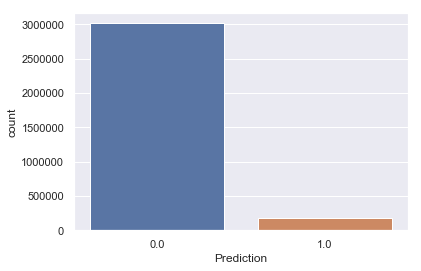

In [20]:
sns.countplot(cust_train_merged.Prediction)
hide_toggle()

### Store

In [21]:
store_impute = store_data[store_data.Store_Format.isnull()][['Store_Format','Mall_Name']]
# Imputing null stores with STANDALONE in store format column.
store_impute['Store_Format'] = (np.where(store_impute ['Mall_Name'] == 'STANDALONE', 'Stand Alone Stores', 'Mall Stores'))
store_data.iloc[store_impute.index,7] = store_impute.iloc[:,0]
# If launch date is before 2015 then 0, else 1 (Recent)
store_data['Recency'] = np.where(store_data.Store_Launch_Date.dt.year < 2015,0,1)

In [22]:
store_data.head()

,Territory,Business,Region,Region_Code,Store_Code,Store_Name,Mall_Name,Store_Format,Sales_Per_Day,Store_Launch_Date,Train_Test_Store,Geo_Field,Store_Size_Sq_Ft,Customer_Count,Total_Revenue,Recency
0,United Arab Emirates,Max,MX - Abu Dhabi,602,60077,Max Zayed City Mall,City Mall - Abu Dhabi-Uae,Mall Stores,544.074849,2011-11-02,Train,"25.618167, 53.441646",4852.220341,22237.0,1.131676e+07,0
1,United Arab Emirates,Max,MX - Sharjah,606,60073,Max Safeer Mall,Safeer Mall Sharjah-Uae,Mall Stores,1251.656549,2009-08-21,Train,"25.309997, 55.378550",13789.949661,88372.0,2.603446e+07,0
2,United Arab Emirates,Max,MX - Dubai,601,60065,Max Gardens,Ibn Battuta Mall-Uae,Mall Stores,3319.885702,2005-04-15,Train,"25.044684, 55.120275",15609.687991,188836.0,6.905362e+07,0
3,United Arab Emirates,Max,MX - Dubai,601,60219,MX -Dubai Festival City,Dubai Festival City-Uae,Stand Alone Stores,1211.477261,2014-06-12,Train,"25.218486, 55.359313",6845.497058,96733.0,2.519873e+07,0
4,United Arab Emirates,Max,MX - Ras Al Khaimah,605,60071,Max Rak,STANDALONE,Stand Alone Stores,2221.872874,2006-03-20,Train,NaN,12385.047461,70456.0,4.621496e+07,0


In [23]:
def store_map(x):
    if x < 6000:
        return 0
    if x <12000:
        return 1
    if x < 18000:
        return 2
    if x < 24000:
        return 3
    else:
        return 4

In [24]:
# Binning Store Size Sq ft.
store_data.Store_Size_Sq_Ft = store_data.Store_Size_Sq_Ft.apply(store_map)

In [25]:
#  Dropping columns with 0 variance or just intuition
store_data.drop(['Territory','Business','Region','Store_Name','Mall_Name','Train_Test_Store','Customer_Count','Geo_Field','Store_Launch_Date'], axis = 1, inplace = True)

In [26]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
store_data.Store_Format = le1.fit_transform(store_data.Store_Format)


In [27]:
store_data[['Region_Code']] = store_data[['Region_Code']].astype('category')

### Customer Demographics

In [28]:
demo_data.Age = demo_data.Age.fillna(np.mean(demo_data.Age))
demo_data.Points = demo_data.Points.fillna(np.mean(demo_data.Points))

In [29]:
demo_data.head()

,Customer_ID,Territory,Nationality,Income_Range,Job_Type,Marital_Status,Gender,State,Language,Loyalty_Status,Birth_date,Age,Points,First_txn_dt,Last_accr_txn_dt,Last_rdm_txn_dt
0,1800000006365760,United Arab Emirates,INDIA,Below 5000,Services,Married,M,Abu Dhabi,English,Gold,01JUN1959:00:00:00,59.000000,814.0,02NOV2010:00:00:00,27SEP2018:21:45:25,11MAR2018:19:11:57
1,1800000006365820,United Arab Emirates,UNITED ARAB EMIRATES,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,37.032096,212.0,06DEC2010:00:00:00,16AUG2016:21:08:28,16MAR2015:13:39:12
2,1800000006366060,United Arab Emirates,SRI LANKA,Below 5000,Services,Married,M,Abu Dhabi,English,Silver,07JUN1959:00:00:00,59.000000,186.0,17FEB2011:00:00:00,31AUG2018:20:52:18,30JAN2017:19:19:19
3,1800000006366230,United Arab Emirates,JORDAN,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,21JAN1962:00:00:00,57.000000,126.0,30OCT2010:00:00:00,30JUL2018:20:30:05,20JUN2017:17:57:27
4,1800000006366570,United Arab Emirates,OCCUPIED PALESTINIAN TERRITORY,Below 5000,Services,Married,M,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,37.032096,197.0,10NOV2010:00:00:00,03SEP2018:22:10:56,17JUN2017:23:08:28


**Finding all the countries which have been mentioned less than 100**

In [30]:
nationality_df = pd.DataFrame(demo_data.Nationality.value_counts().sort_values(0)).reset_index()
nationality_df.columns = ['Country','Count']
countries_to_update = nationality_df[nationality_df.Count < 100]['Country'].tolist()

**Converting all those countries to others**

In [31]:
def modify_nationality(x):
    if x in (countries_to_update):
        return 'Others'
    else:
        return x
# Nationality < 100 - club them
demo_data.Nationality = demo_data.Nationality.apply(modify_nationality)

In [32]:
le2 = LabelEncoder()
demo_data.Income_Range = le2.fit_transform(demo_data.Income_Range)

In [33]:
demo_data.Marital_Status.value_counts()

Unspecified    92484
Married         6522
Single           982
Widowed            5
Divorsed           4
Separated          2
Others             1
Name: Marital_Status, dtype: int64

**Converting Marital_Status to binary - Specified or unspecified**

In [34]:
def update_marital_status(x):
    if x in ('Unspecified'):
        return 'Unspecified'
    else:
        return 'Specified'
demo_data.Marital_Status = demo_data.Marital_Status.apply(update_marital_status)

In [35]:
demo_data.Age.describe()

count    100000.000000
mean         37.032096
std           8.012130
min           1.000000
25%          33.000000
50%          37.032096
75%          40.000000
max         137.000000
Name: Age, dtype: float64

**Age > 100 doesn't make sense. Here, we can see max as 137. Hence, any age  > 80 has been mapped to 85.**

In [36]:
def update_age(x):
    if x > 80:
        return 85
    else:
        return x
demo_data.Age = demo_data.Age.apply(update_age)

In [37]:
# Age - Perform Binning 
demo_data.Age = pd.cut(demo_data.Age, np.arange(0,100,10), labels = [0,1,2,3,4,5,6,7,8],\
       include_lowest=True, right = True)

In [38]:
demo_data.isnull().sum()

Customer_ID             0
Territory               0
Nationality             0
Income_Range            0
Job_Type                0
Marital_Status          0
Gender                  0
State                   0
Language                0
Loyalty_Status          0
Birth_date          17538
Age                     0
Points                  0
First_txn_dt           33
Last_accr_txn_dt        6
Last_rdm_txn_dt     28419
dtype: int64

Converting First_txn_dt & Last_accr_txn_dt to datetime format.

In [39]:
for i in ['First_txn_dt', 'Last_accr_txn_dt']:
    demo_data[i] = pd.to_datetime(demo_data[i], format="%d%b%Y:%H:%M:%S")

In [40]:
demo_data['Customer_Lifetime'] = abs(demo_data['Last_accr_txn_dt'] - demo_data['First_txn_dt'])
demo_data['Customer_Lifetime'] = demo_data['Customer_Lifetime'].dt.days

In [41]:
demo_data['Customer_Recency'] = demo_data.Last_accr_txn_dt.dt.year.apply(lambda x: 2018-x)

In [42]:
demo_data['Last_transact_month'] = demo_data.Last_accr_txn_dt.dt.month

In [43]:
demo_data.Customer_Lifetime = demo_data.Customer_Lifetime.fillna(np.mean(demo_data.Customer_Lifetime))
demo_data.Customer_Recency = demo_data.Customer_Recency.fillna(np.mean(demo_data.Customer_Recency))
demo_data.Last_transact_month = demo_data.Last_transact_month.fillna(np.mean(demo_data.Last_transact_month))

In [44]:
demo_data.drop(['Territory', 'Birth_date','Last_rdm_txn_dt','Job_Type','Last_accr_txn_dt','First_txn_dt'], axis=1, inplace=True)

In [45]:
demo_data.head(5)

,Customer_ID,Nationality,Income_Range,Marital_Status,Gender,State,Language,Loyalty_Status,Age,Points,Customer_Lifetime,Customer_Recency,Last_transact_month
0,1800000006365760,INDIA,4,Specified,M,Abu Dhabi,English,Gold,5,814.0,2886.0,0.0,9.0
1,1800000006365820,UNITED ARAB EMIRATES,4,Specified,F,Abu Dhabi,Arabic,Silver,3,212.0,2080.0,2.0,8.0
2,1800000006366060,SRI LANKA,4,Specified,M,Abu Dhabi,English,Silver,5,186.0,2752.0,0.0,8.0
3,1800000006366230,JORDAN,4,Specified,F,Abu Dhabi,Arabic,Silver,5,126.0,2830.0,0.0,7.0
4,1800000006366570,OCCUPIED PALESTINIAN TERRITORY,4,Specified,M,Abu Dhabi,Arabic,Silver,3,197.0,2854.0,0.0,9.0


**Label Encoding String inputs to Numerical**

In [46]:
le3 = LabelEncoder()
demo_data.Nationality = le3.fit_transform(demo_data.Nationality)

le4 = LabelEncoder()
demo_data.Marital_Status = le4.fit_transform(demo_data.Marital_Status)

le5 = LabelEncoder()
demo_data.Gender = le5.fit_transform(demo_data.Gender)

le6 = LabelEncoder()
demo_data.State = le6.fit_transform(demo_data.State)

le7 = LabelEncoder()
demo_data.Language = le7.fit_transform(demo_data.Language)

le8 = LabelEncoder()
demo_data.Loyalty_Status = le8.fit_transform(demo_data.Loyalty_Status)

**Converting Above columns to Categorical so that algorithm doesn't confuse it as numeric.**

In [47]:
demo_data[['Nationality','Income_Range','Marital_Status','Gender', 'State', 'Language', 'Loyalty_Status']] = demo_data[['Nationality','Income_Range','Marital_Status','Gender', 'State', 'Language', 'Loyalty_Status']].astype('category')

### Merge All Datasets 

In [48]:
train_df = pd.merge(cust_train_merged, demo_data, how = 'left', left_on='Customer_ID', right_on='Customer_ID')

In [49]:
train_cus_df = pd.merge(train_df,cust_group, how = 'left', left_on='Customer_ID', right_on='Customer_ID')

In [50]:
train_final_df = pd.merge(train_cus_df, store_data, how = 'left', left_on='Store_Code', right_on='Store_Code')

In [51]:
train_final_df.shape

(3200000, 23)

In [52]:
train_final_df.columns

Index(['Customer_ID', 'Store_Code', 'Visits', 'Prediction', 'Nationality',
       'Income_Range', 'Marital_Status', 'Gender', 'State', 'Language',
       'Loyalty_Status', 'Age', 'Points', 'Customer_Lifetime',
       'Customer_Recency', 'Last_transact_month', 'Invoices', 'Region_Code',
       'Store_Format', 'Sales_Per_Day', 'Store_Size_Sq_Ft', 'Total_Revenue',
       'Recency'],
      dtype='object')

**The Store_Code 60084 is not present in transactions dataset, but it is present in stores. Hence dropping those rows now.**

In [53]:
train_final_df.drop(train_final_df[train_final_df.Store_Code == 60084].index, axis=0, inplace=True)

### Importing Test Data

### Merging Customer Demographics with Test Data

In [54]:
%%time
test_data = pd.read_excel("Test_Set.xlsx")

Wall time: 16.7 s


In [55]:
test_df1 = pd.merge(test_data,demo_data , how = 'left', left_on='Customer_ID', right_on='Customer_ID')
test_cus_df = pd.merge(test_df1,cust_group, how = 'left', left_on='Customer_ID', right_on='Customer_ID')

In [56]:
test_final_df = pd.merge(test_cus_df, store_data, how = 'left', left_on='Store_Code', right_on='Store_Code')

In [57]:
test_final_df.shape

(400000, 21)

In [58]:
# train_final_df.to_csv('Train_fe_2.csv', index = False)
# test_final_df.to_csv('Test_fe_2.csv', index = False)

In [59]:
train_final_df[['Prediction','Customer_Recency','Last_transact_month','Store_Format','Recency']] = train_final_df[['Prediction','Customer_Recency','Last_transact_month','Store_Format','Recency']].astype('category')
test_final_df[['Customer_Recency','Last_transact_month','Store_Format','Recency']] = test_final_df[['Customer_Recency','Last_transact_month','Store_Format','Recency']].astype('category')


## 2. Use distance between each store and then formulate hypothesis based on that.

This was the idea which I initially tried, but couldn't work through it. So I went with ML way(previous way)
This code is borrowed from the winner of the hackathon - Sajan Kumar Bhagat __[Github_URL](https://github.com/bhagatsajan0073/LandMark-Group-Data-Science-Hiring-Challenge-Final-Solution)__

In [1]:
# %load required.py
import pandas as pd
import numpy as np
import sklearn
import warnings
import dateutil.parser
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings(action='ignore')

### Test Data

In [2]:
test_data=pd.read_excel("Test_Set.xlsx")

In [3]:
test_data.head()

,Customer_ID,Store_Code
0,1800000006365760,60298
1,1800000006365760,60299
2,1800000006365760,60300
3,1800000006365760,60301
4,1800000006365820,60298


### Customer Transaction

In [4]:
customer_transactions=pd.read_excel('Customer_Transaction.xlsx')

In [5]:
customer_transactions.head()

,Territory,Business,Year,Week,Store_Code,City_Name,Store_Type,Transaction_Type,Return_Reason,Customer_ID,Invoices,Item_Count,Revenue,Discount,Units_Sold
0,United Arab Emirates,Max,2010,0,60065,Dubai,Stand alone,Return,Size Problem,1800000058056860,1,3,-169.0,0.0,-3
1,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000020917140,1,1,0.0,0.0,0
2,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000021265010,1,1,0.0,0.0,0
3,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000025693950,1,4,0.0,0.0,0
4,United Arab Emirates,Max,2016,0,60053,NaN,NaN,Purchase,NaN,1800000044104620,1,1,0.0,0.0,0


In [6]:
t_count=customer_transactions[['Customer_ID','Store_Code','Year']].groupby(['Customer_ID','Store_Code'])['Year'].agg({"Transaction Count":len}).reset_index()
t_count.head()

,Customer_ID,Store_Code,Transaction Count
0,1800000006365760,60067,4
1,1800000006365820,60054,1
2,1800000006366060,60066,1
3,1800000006366060,60069,1
4,1800000006366060,60079,2


### No. of transactions a customer has done in any store

In [7]:
customer_store_transactions=t_count.sort_values(['Customer_ID','Store_Code']).pivot_table(values='Transaction Count', index='Customer_ID', columns='Store_Code').reset_index()
customer_store_transactions.fillna(0,inplace=True)
customer_store_transactions.head()
# customer_store_transactions.to_csv("./customer_store_transaction.csv",index=False)

Store_Code,Customer_ID,60053,60054,60055,60057,60058,60059,60060,60061,60062,...,60076,60077,60079,60084,60086,60219,60233,60241,60250,60275
0,1800000006365760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1800000006365820,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1800000006366060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,1800000006366230,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1800000006366570,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating a flag whether a customer had made any transaction for purticular store or not ?

In [8]:
for col in customer_store_transactions.columns[1:]:
    customer_store_transactions[col]=customer_store_transactions[col].apply(lambda x:1 if x>0 else 0)
#     customer_store_transactions[col]=customer_store_transactions[col].apply(lambda x:1 if x>1 else 0)

In [9]:
customer_store_transactions.head()

Store_Code,Customer_ID,60053,60054,60055,60057,60058,60059,60060,60061,60062,...,60076,60077,60079,60084,60086,60219,60233,60241,60250,60275
0,1800000006365760,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1800000006365820,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1800000006366060,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1800000006366230,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1800000006366570,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# customer_store_transactions.to_csv("./customer_store_transaction_flags.csv",index=False)

### Customer Demographics

In [10]:
customer_demographics=pd.read_excel("Customer_Demographics.xlsx")

In [11]:
customer_demographics.columns

Index(['Customer_ID', 'Territory', 'Nationality', 'Income_Range', 'Job_Type',
       'Marital_Status', 'Gender', 'State', 'Language', 'Loyalty_Status',
       'Birth_date', 'Age', 'Points', 'First_txn_dt', 'Last_accr_txn_dt',
       'Last_rdm_txn_dt'],
      dtype='object')

In [12]:
# print("Different Demographics cutomer belong to :",customer_demographics.Territory.unique())
# print("Different Nationality cutomer belong to : \n",customer_demographics.Nationality.value_counts().head(10)*100/customer_demographics.shape[0])
# print("Different Income_Range cutomer belong to : \n",customer_demographics.Income_Range.value_counts())
# print("Different Job_Type cutomer belong to : \n",customer_demographics.Job_Type.value_counts())
# print("Different Marital_Status cutomer belong to : \n",customer_demographics.Marital_Status.value_counts())
# print("Different Gender cutomer belong to : \n",customer_demographics.Gender.value_counts())
print("Different State cutomer belong to : \n",customer_demographics.State.value_counts())

Different State cutomer belong to : 
 Abu Dhabi         41715
Dubai             23189
Others            11619
Sharjah           10919
Unspecified        4804
Ras Al Khaimah     2840
Ajman              2593
Fujairah           2074
Umm Al Quwain       243
Muscat                1
Bahrain               1
Kuwait City           1
Qatar                 1
Name: State, dtype: int64


In [13]:
customer_demographics.head()

,Customer_ID,Territory,Nationality,Income_Range,Job_Type,Marital_Status,Gender,State,Language,Loyalty_Status,Birth_date,Age,Points,First_txn_dt,Last_accr_txn_dt,Last_rdm_txn_dt
0,1800000006365760,United Arab Emirates,INDIA,Below 5000,Services,Married,M,Abu Dhabi,English,Gold,01JUN1959:00:00:00,59.0,814.0,02NOV2010:00:00:00,27SEP2018:21:45:25,11MAR2018:19:11:57
1,1800000006365820,United Arab Emirates,UNITED ARAB EMIRATES,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,NaN,212.0,06DEC2010:00:00:00,16AUG2016:21:08:28,16MAR2015:13:39:12
2,1800000006366060,United Arab Emirates,SRI LANKA,Below 5000,Services,Married,M,Abu Dhabi,English,Silver,07JUN1959:00:00:00,59.0,186.0,17FEB2011:00:00:00,31AUG2018:20:52:18,30JAN2017:19:19:19
3,1800000006366230,United Arab Emirates,JORDAN,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,21JAN1962:00:00:00,57.0,126.0,30OCT2010:00:00:00,30JUL2018:20:30:05,20JUN2017:17:57:27
4,1800000006366570,United Arab Emirates,OCCUPIED PALESTINIAN TERRITORY,Below 5000,Services,Married,M,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,NaN,197.0,10NOV2010:00:00:00,03SEP2018:22:10:56,17JUN2017:23:08:28


In [14]:
customer_demographics[['Gender','Loyalty_Status','State','Income_Range']].describe()

,Gender,Loyalty_Status,State,Income_Range
count,100000,100000,100000,100000
unique,3,2,13,7
top,M,Silver,Abu Dhabi,Unspecified
freq,52524,92196,41715,92853


In [15]:
for i in ['First_txn_dt', 'Last_accr_txn_dt','Last_rdm_txn_dt']:
    customer_demographics[i] = pd.to_datetime(customer_demographics[i], format="%d%b%Y:%H:%M:%S")

In [16]:
customer_demographics.isnull().sum()

Customer_ID             0
Territory               0
Nationality             0
Income_Range            0
Job_Type                0
Marital_Status          0
Gender                  0
State                   0
Language                0
Loyalty_Status          0
Birth_date          17538
Age                 26096
Points               2863
First_txn_dt           33
Last_accr_txn_dt        6
Last_rdm_txn_dt     28419
dtype: int64

In [17]:
customer_demographics['ds_ft_purchase']=(customer_demographics['Last_accr_txn_dt']-customer_demographics['First_txn_dt'])
customer_demographics['lt_date']=customer_demographics[['Last_accr_txn_dt','Last_rdm_txn_dt']].apply(max,axis=1)

In [18]:
customer_demographics['lt_month']=customer_demographics['lt_date'].apply(lambda x:x.month)
customer_demographics['lt_year']=customer_demographics['lt_date'].apply(lambda x:x.year)
customer_demographics.head()

,Customer_ID,Territory,Nationality,Income_Range,Job_Type,Marital_Status,Gender,State,Language,Loyalty_Status,Birth_date,Age,Points,First_txn_dt,Last_accr_txn_dt,Last_rdm_txn_dt,ds_ft_purchase,lt_date,lt_month,lt_year
0,1800000006365760,United Arab Emirates,INDIA,Below 5000,Services,Married,M,Abu Dhabi,English,Gold,01JUN1959:00:00:00,59.0,814.0,2010-11-02,2018-09-27 21:45:25,2018-03-11 19:11:57,2886 days 21:45:25,2018-09-27 21:45:25,9.0,2018.0
1,1800000006365820,United Arab Emirates,UNITED ARAB EMIRATES,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,NaN,212.0,2010-12-06,2016-08-16 21:08:28,2015-03-16 13:39:12,2080 days 21:08:28,2016-08-16 21:08:28,8.0,2016.0
2,1800000006366060,United Arab Emirates,SRI LANKA,Below 5000,Services,Married,M,Abu Dhabi,English,Silver,07JUN1959:00:00:00,59.0,186.0,2011-02-17,2018-08-31 20:52:18,2017-01-30 19:19:19,2752 days 20:52:18,2018-08-31 20:52:18,8.0,2018.0
3,1800000006366230,United Arab Emirates,JORDAN,Below 5000,Services,Married,F,Abu Dhabi,Arabic,Silver,21JAN1962:00:00:00,57.0,126.0,2010-10-30,2018-07-30 20:30:05,2017-06-20 17:57:27,2830 days 20:30:05,2018-07-30 20:30:05,7.0,2018.0
4,1800000006366570,United Arab Emirates,OCCUPIED PALESTINIAN TERRITORY,Below 5000,Services,Married,M,Abu Dhabi,Arabic,Silver,01JAN1900:00:00:00,NaN,197.0,2010-11-10,2018-09-03 22:10:56,2017-06-17 23:08:28,2854 days 22:10:56,2018-09-03 22:10:56,9.0,2018.0


### Store Dataset

In [32]:
store_master=pd.read_excel("Store_Master.xlsx")

In [33]:
store_master.head()

,Territory,Business,Region,Region_Code,Store_Code,Store_Name,Mall_Name,Store_Format,Sales_Per_Day,Store_Launch_Date,Train_Test_Store,Geo_Field,Store_Size_Sq_Ft,Customer_Count,Total_Revenue
0,United Arab Emirates,Max,MX - Abu Dhabi,602,60077,Max Zayed City Mall,City Mall - Abu Dhabi-Uae,NaN,544.074849,2011-11-02,Train,"25.618167, 53.441646",4852.220341,22237.0,1.131676e+07
1,United Arab Emirates,Max,MX - Sharjah,606,60073,Max Safeer Mall,Safeer Mall Sharjah-Uae,NaN,1251.656549,2009-08-21,Train,"25.309997, 55.378550",13789.949661,88372.0,2.603446e+07
2,United Arab Emirates,Max,MX - Dubai,601,60065,Max Gardens,Ibn Battuta Mall-Uae,NaN,3319.885702,2005-04-15,Train,"25.044684, 55.120275",15609.687991,188836.0,6.905362e+07
3,United Arab Emirates,Max,MX - Dubai,601,60219,MX -Dubai Festival City,Dubai Festival City-Uae,Stand Alone Stores,1211.477261,2014-06-12,Train,"25.218486, 55.359313",6845.497058,96733.0,2.519873e+07
4,United Arab Emirates,Max,MX - Ras Al Khaimah,605,60071,Max Rak,STANDALONE,NaN,2221.872874,2006-03-20,Train,NaN,12385.047461,70456.0,4.621496e+07


In [34]:
store_master[store_master.Train_Test_Store=='Test']

,Territory,Business,Region,Region_Code,Store_Code,Store_Name,Mall_Name,Store_Format,Sales_Per_Day,Store_Launch_Date,Train_Test_Store,Geo_Field,Store_Size_Sq_Ft,Customer_Count,Total_Revenue
31,United Arab Emirates,Max,MX - Abu Dhabi,602,60301,MAX- Abudhabi Al Wahda,AL Wahda,Mall Stores,10861.009520,2018-01-30,Test,"24.470587, 54.372679",23288.338616,NaN,7472374.550
32,United Arab Emirates,Max,MX - Sharjah,606,60298,MAX - Matejer Al Juraina,Matejer Al Juraina,Mall Stores,4099.543401,2018-01-07,Test,"25.296484, 55.489202",8391.589347,NaN,2820485.860
33,United Arab Emirates,Max,MX - Abu Dhabi,602,60300,MAX-WTC,WTC,Mall Stores,7036.233391,2018-02-01,Test,"24.487658, 54.357529",6604.762130,NaN,2701913.622
34,United Arab Emirates,Max,MX - Abu Dhabi,602,60299,MAX-Alain Mall,Alain Mall,Mall Stores,5157.825699,2018-02-01,Test,"24.222016, 55.781629",3266.388547,NaN,479677.790


In [35]:
store_master[store_master.Geo_Field.isnull()&store_master.Region_Code.isin((602,606))]

,Territory,Business,Region,Region_Code,Store_Code,Store_Name,Mall_Name,Store_Format,Sales_Per_Day,Store_Launch_Date,Train_Test_Store,Geo_Field,Store_Size_Sq_Ft,Customer_Count,Total_Revenue
6,United Arab Emirates,Max,MX - Sharjah,606,60075,Max Sharjah Qassimia,STANDALONE,NaN,2268.223683,2011-02-11,Train,NaN,9582.354867,113795.0,4.717905e+07
15,United Arab Emirates,Max,MX - Sharjah,606,60074,Max Sharjah,STANDALONE,NaN,2631.139338,2004-07-21,Train,NaN,3467.799125,137253.0,5.472770e+07
28,United Arab Emirates,Max,MX - Abu Dhabi,602,60053,Max Abudhabi,STANDALONE,NaN,3094.424495,2004-05-16,Train,NaN,19200.122169,160218.0,6.436403e+07


In [39]:
# store_master[(store_master.Region_Code==602)&(store_master.Train_Test_Store!='Test')]

## Solution 1 : Customers of stores in same region and visited to newely opened stores are most likely to visit the newely opened store

In [36]:
from itertools import combinations_with_replacement,combinations
import geopy.distance

comb=list(combinations(list(store_master[(store_master['Region_Code'].isin([602,606]))&\
                                         (~store_master['Geo_Field'].isnull())]['Geo_Field'].values),2))

print("$"*30," Total Number of Combination : ",len(comb),"$"*30)
print()
print()

store_distance=[]
for i in comb[:]:
    coords_1,coords_2=tuple(map(float,i[0].split(","))),tuple(map(float,i[1].split(",")))
    store_distance.append({"source":i[0],"destination":i[1],"distance":geopy.distance.vincenty(coords_1, coords_2).km})

print("$"*35," Distance Dataframe ","$"*35)
print()
print()
   
distance_df=pd.DataFrame.from_records(store_distance)
print(distance_df.head(10))


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$  Total Number of Combination :  105 $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$  Distance Dataframe  $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


            destination    distance                source
0  25.309997, 55.378550  197.756704  25.618167, 53.441646
1  24.476186, 54.321439  154.545281  25.618167, 53.441646
2  24.312255, 54.619651  187.283174  25.618167, 53.441646
3  25.325119, 55.393559  198.951334  25.618167, 53.441646
4  24.434721, 54.412599  163.671819  25.618167, 53.441646
5  24.321044, 54.480138  177.878220  25.618167, 53.441646
6  24.322808, 54.480221  177.724939  25.618167, 53.441646
7  24.170905, 55.808654  287.904123  25.618167, 53.441646
8  24.333514, 54.523955  179.420909  25.618167, 53.441646
9  24.503005, 54.382945  155.820654  25.618167, 53.441646


In [23]:
# print(store_master[(store_master['Region_Code'].isin([602,606]))&\
#              (~store_master['Geo_Field'].isnull())][['Store_Code','Geo_Field']].Geo_Field.unique())

# len(set(distance_df.destination.unique()).union(set(distance_df.source.unique())))

In [37]:
distance_df_map=pd.merge(pd.merge(distance_df,store_master[(store_master['Region_Code'].isin([602,606]))&(~store_master['Geo_Field'].isnull())][['Store_Code','Geo_Field']],left_on='source',right_on='Geo_Field',how='left'),store_master[(store_master['Region_Code'].isin([602,606]))&(~store_master['Geo_Field'].isnull())][['Store_Code','Geo_Field']],how='left',left_on='destination',right_on='Geo_Field')[['Store_Code_x','Store_Code_y','distance']]
distance_df_map.columns=['Source_Store_Code','Destination_Sorce_Code','Distance']
distance_df_map.head()

,Source_Store_Code,Destination_Sorce_Code,Distance
0,60077,60073,197.756704
1,60077,60067,154.545281
2,60077,60058,187.283174
3,60077,60076,198.951334
4,60077,60069,163.671819


In [38]:
distance_df_final=distance_df_map[distance_df_map.Source_Store_Code!=distance_df_map.Destination_Sorce_Code]
distance_df_final.drop_duplicates(inplace=True)
distance_df_final.shape

(105, 3)

In [39]:
distance_df_map=pd.merge(pd.merge(distance_df,store_master[(store_master['Region_Code'].isin([602,606]))&(~store_master['Geo_Field'].isnull())][['Store_Code','Geo_Field']],left_on='source',right_on='Geo_Field',how='left'),store_master[(store_master['Region_Code'].isin([602,606]))&(~store_master['Geo_Field'].isnull())][['Store_Code','Geo_Field']],how='left',left_on='destination',right_on='Geo_Field')[['Store_Code_x','Store_Code_y','distance']]
distance_df_map.columns=['Source_Store_Code','Destination_Sorce_Code','Distance']

distance_df_final=distance_df_map[distance_df_map.Source_Store_Code!=distance_df_map.Destination_Sorce_Code]
distance_df_final=distance_df_map.copy()
del distance_df_map,distance_df

In [40]:
distance_df_final[distance_df_final.Source_Store_Code.isin([60298])|distance_df_final.Destination_Sorce_Code.isin([60298])].sort_values("Distance").head()


,Source_Store_Code,Destination_Sorce_Code,Distance
57,60076,60298,10.139697
24,60073,60298,11.242858
103,60298,60299,122.638140
87,60057,60298,128.799441
47,60058,60298,140.055583


In [41]:
distance_df_final.head()

,Source_Store_Code,Destination_Sorce_Code,Distance
0,60077,60073,197.756704
1,60077,60067,154.545281
2,60077,60058,187.283174
3,60077,60076,198.951334
4,60077,60069,163.671819


#### Develop hypothesis based on store proximity 

In [42]:
distance_df_final[distance_df_final.Source_Store_Code.isin([60298])|distance_df_final.Destination_Sorce_Code.isin([60298])].sort_values("Distance").head()

,Source_Store_Code,Destination_Sorce_Code,Distance
57,60076,60298,10.139697
24,60073,60298,11.242858
103,60298,60299,122.638140
87,60057,60298,128.799441
47,60058,60298,140.055583


In [43]:
# hypo-thesis based on store distance 
# customer from store 60076 and 60073 might visit 60298
# 60057,60058 would never visit 

customer_60298=customer_store_transactions[['Customer_ID',60076,60073]] # 60073,60074,
customer_60298['pred']=customer_60298[[60076,60073]].apply(max,axis=1) #60073,60074,
customer_60298['Store_Code']=60298

In [44]:
distance_df_final[distance_df_final.Source_Store_Code.isin([60299])|distance_df_final.Destination_Sorce_Code.isin([60299])].sort_values("Distance").head()

,Source_Store_Code,Destination_Sorce_Code,Distance
89,60057,60299,6.291800
49,60058,60299,118.410220
103,60298,60299,122.638140
26,60073,60299,127.223380
94,60054,60299,128.289733


In [45]:
customer_60299=customer_store_transactions[['Customer_ID',60057]]
customer_60299['pred']=customer_60299[[60057]].apply(max,axis=1)
customer_60299['Store_Code']=60299

In [46]:
distance_df_final[distance_df_final.Source_Store_Code.isin([60300])|distance_df_final.Destination_Sorce_Code.isin([60300])].sort_values("Distance").head(10)


,Source_Store_Code,Destination_Sorce_Code,Distance
100,60301,60300,2.435983
97,60275,60300,3.086447
37,60067,60300,3.872814
67,60069,60300,8.096594
82,60233,60300,22.097036
75,60079,60300,22.254104
93,60054,60300,24.009216
48,60058,60300,32.930187
25,60073,60300,137.617513
58,60076,60300,139.858390


In [48]:
customer_60300=customer_store_transactions[['Customer_ID',60275,60067,60069]]
customer_60300['pred']=customer_60300[[60275,60067,60069]].apply(max,axis=1)
customer_60300['Store_Code']=60300

In [49]:
distance_df_final[distance_df_final.Source_Store_Code.isin([60301])|distance_df_final.Destination_Sorce_Code.isin([60301])].sort_values("Distance").head(10)


,Source_Store_Code,Destination_Sorce_Code,Distance
100,60301,60300,2.435983
95,60275,60301,3.738536
35,60067,60301,5.231402
65,60069,60301,5.671447
80,60233,60301,19.670593
73,60079,60301,19.828889
91,60054,60301,21.586263
46,60058,60301,30.581486
23,60073,60301,137.748365
56,60076,60301,139.993486


In [50]:
customer_60301=customer_store_transactions[['Customer_ID',60275,60067,60069]] #60054,60058
customer_60301['pred']=customer_60301[[60275,60067,60069]].apply(max,axis=1)
customer_60301['Store_Code']=60301
# customer_60301['proximity_count']=customer_60301[[60275,60067,60069,60233,60079,60054,60053,60077]].apply(sum,axis=1)
# customer_60301['pred']=customer_60301['proximity_count'].apply(lambda x:1 if x==1 else 0)

In [51]:
result=pd.concat([customer_60298[['Customer_ID','pred','Store_Code']],customer_60299[['Customer_ID','pred','Store_Code']],\
           customer_60300[['Customer_ID','pred','Store_Code']],customer_60301[['Customer_ID','pred','Store_Code']]],axis=0)
result.rename(columns={'pred':'Prediction'},inplace=True)
result[['Customer_ID','Store_Code','Prediction']]['Store_Code'].value_counts()

60298    100000
60299    100000
60300    100000
60301    100000
Name: Store_Code, dtype: int64

In [86]:
# pd.merge(test_data,result[['Customer_ID','Store_Code','Prediction']]).to_csv("./distance.csv",index=False)

### Customers who had made purchase in last 4 months or after may 2018 is most likely to visit the store in the same region

In [52]:
def receny_pred(row):
    if((row['lt_year']==2018) and (row['lt_month']>5)): #5
        return 1
    else:
        return 0

In [53]:
customer_demographics['pred']=customer_demographics.apply(receny_pred,axis=1)

In [54]:
df=pd.merge(result[['Customer_ID','Store_Code','Prediction']],customer_demographics[['Customer_ID','pred']],left_on='Customer_ID',right_on='Customer_ID',how='left')

In [55]:
df.head()

,Customer_ID,Store_Code,Prediction,pred
0,1800000006365760,60298,0,1
1,1800000006365820,60298,0,0
2,1800000006366060,60298,0,1
3,1800000006366230,60298,0,1
4,1800000006366570,60298,0,1


In [56]:
# Intersection of prediction and pred columns
def recency_twik(row):
    if(row['Prediction']):
        if(row['pred']):
            return 1
        elif(~row['pred']):
            return 0
    else:
        return 0


In [57]:
# df[df.pred.isnull()]
print(df.Prediction.value_counts())
print(df.pred.value_counts())

0    334829
1     65171
Name: Prediction, dtype: int64
1    269268
0    130732
Name: pred, dtype: int64


In [58]:
df['prediction']=df.apply(recency_twik,axis=1)

In [59]:
df['prediction'].value_counts()

0    347001
1     52999
Name: prediction, dtype: int64

In [60]:
# For final Submission
# pd.merge(test_data,df[['Customer_ID','Store_Code','prediction']]).rename(columns={'prediction':'Prediction'}).to_csv("./proximity_hypothesis_submission.csv",index=False)

In [62]:
# For final Submission
df2 = pd.merge(test_data,df[['Customer_ID','Store_Code','prediction']]).rename(columns={'prediction':'Prediction'})

In [63]:
print(df.Prediction.value_counts())
print(df.pred.value_counts())

0    334829
1     65171
Name: Prediction, dtype: int64
1    269268
0    130732
Name: pred, dtype: int64
